In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warehouse
import seaborn as sb

Read Data
---

In [2]:
import os
import sys


ga_df = None
greedy_df = None
cws_df = None
tabu_df = None

with open("../results/ga", "r") as ga_file,\
     open("../results/greedy", "r") as greedy_file,\
     open("../results/cws", "r") as cws_file,\
     open("../results/tabu", "r") as tabu_file:
    ga_df = warehouse.read(ga_file.read())
    greedy_df = warehouse.read(greedy_file.read())
    cws_df = warehouse.read(cws_file.read())
    tabu_df = warehouse.read(tabu_file.read())

print(os.path.abspath(os.pardir))

/Users/jonval/WARNING/School/KeX/warehouse_cpp


Score Distribution
---

/usr/local/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


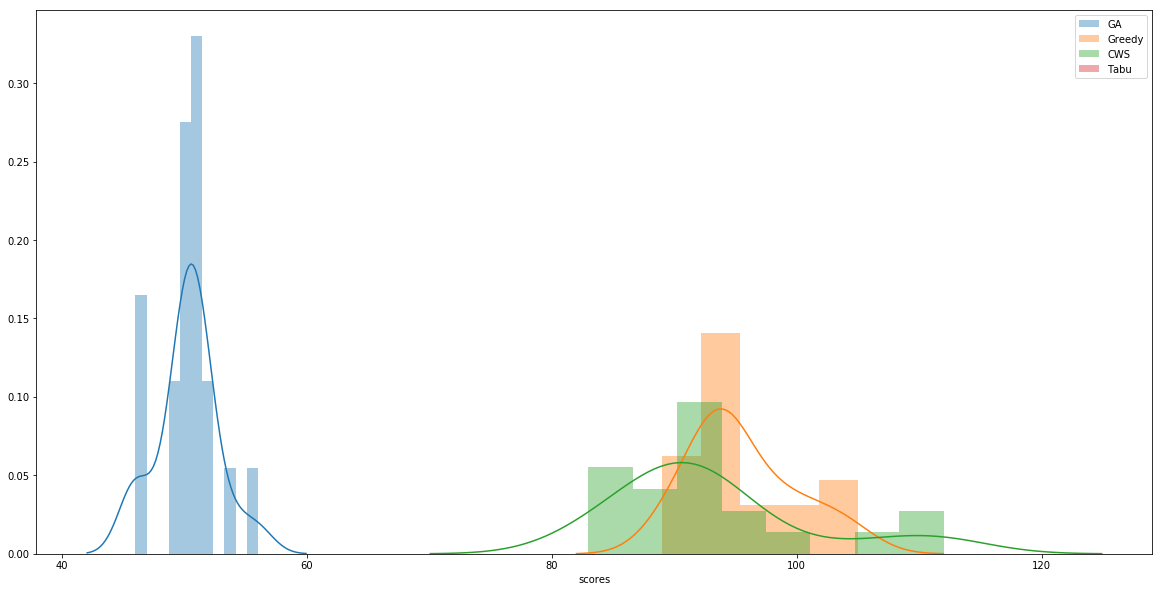

In [3]:
fig, ax = plt.subplots(1, figsize=(20, 10))


sb.distplot(ga_df["scores"], label="GA", ax=ax)
ax.legend()

sb.distplot(greedy_df["scores"], label="Greedy", ax=ax)
ax.legend()

sb.distplot(cws_df["scores"], label="CWS", ax=ax)
ax.legend()

sb.distplot(tabu_df["scores"], label="Tabu", ax=ax)
ax.legend()


plt.show()